<a href="https://colab.research.google.com/github/Amilcar28/Amilcar28/blob/main/Operations/pycpt_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyCPT Version 2 - Google Colab

This is the current operational PyCPT seasonal climate forecasting workflow. This notebook can be adapted to suit your exact needs through modifications of the code. This notebook uses PyCPT v2 utilities to

1. download data from the IRI Data Library (through the CPT-DL python library)
2. Run bias-correction using the IRI Climate Predictability Tool (through its companion python library, CPT-CORE)
3. Plot skills scores and spatial loadings
4. Produce a multi-model ensemble forecast by taking the simple average of the bias-corrected members
5. Plots skill scores, deterministic forecasts, probabilistic forecasts, and exceedance probabilities for this NextGen MME forecast.

This version of the notebook is modified for compatibility with Google Co-Lab (colab.research.google.com/) and is all executed in a single cell (except for set up) to make managing the environment possible.


### This cell installs Anaconda on Google Colab

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


### This cell uses conda to create the pycpt environment and install dependencies

In [ ]:
!conda create -c iri-nextgen -c conda-forge -n pycpt_env pycpt gfortran_linux-64 make
!mamba install -q -c conda-forge cartopy

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local/envs/pycpt_env

  added / updated specs:
    - gfortran_linux-64
    - make
    - pycpt


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-2_gnu
  alsa-lib           conda-forge/linux-64::alsa-lib-1.2.6.1-h7f98852_0
  argon2-cffi        conda-forge/noarch::argon2-cffi-21.3.0-pyhd8ed1ab_0
  argon2-cffi

### This Cell is all the analysis of PyCPT - results are saved into files.

In [ ]:
%%bash
source activate pycpt_env
python

import cptdl as dl
import cptio as cio
import cptcore as cc
import cptextras as ce

import xarray as xr
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

case_directory = Path.home() / "Desktop" / "pycpt_debugging"
case_directory.mkdir(exist_ok=True, parents=True)

# POE settings
threshold = 0.5
isPercentile = True
point_latitude = 16
point_longitude = 78

MOS = 'CCA' # must be one of 'CCA', 'PCR', or "None"
predictor_names = ['CFSv2.PRCP','GEOSS2S.PRCP' ]
predictand_name = 'UCSB.PRCP'

# use dl.observations.keys() to see all options for predictand
# and dl.hindcasts.keys() to see all options for predictors
# make sure your first_year & final_year are compatible with
# your selections for your predictors and predictands

download_args = {
   # 'fdate':
   #   the initialization date of the model forecasts / hindcasts
   #   this field is defined by a python datetime.datetime object
   #   for example: dt.datetime(2022, 5, 1) # YYYY, MM, DD as integers
   #   The year field is only used for forecasts, otherwise ignored
   #   The day field is only used in subseasonal forecasts, otherwise ignored
   #   The month field is an integer representing a month - ie, May=5
  'fdate': dt.datetime(2022, 5, 1),

   # 'first_year':
   #   the first year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**
   #   double check that your model has hindcast data for all years in [first_year, final_year]
   #   This field is defined by a python integer representing a year, ie: 1993
  'first_year': 1982,

   # 'final_year':
   #   the final year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**
   #   double check that your model has hindcast data for all years in [first_year, final_year]
   #   This field is defined by a python integer representing a year, ie: 2016
  'final_year': 2010,

   # 'predictor_extent':
   #   The geographic bounding box of the climate model data you want to download
   #   This field is defined by a python dictionary with the keys "north", "south",
   #   "east", and "west", each of which maps to a python integer representing the
   #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
   #   "south" the southernmost boundary. Example: {"north": 90, "south": 90, "east": 0, "west": 180}
  'predictor_extent': {
    'east': 100,
    'west': 60,
    'north': 35,
    'south': 0
  },

   # 'predictand_extent':
   #   The geographic bounding box of the observation data you want to download
   #   This field is defined by a python dictionary with the keys "north", "south",
   #   "east", and "west", each of which maps to a python integer representing the
   #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
   #   "south" the southernmost boundary. Example: {"north": 90, "south": 90, "east": 0, "west": 180}
  'predictand_extent': {
    'east': 90,
    'west': 70,
    'north': 30,
    'south': 5
  },

   # 'lead_low':
   #   the number of months from the first of the initialization month to the center of
   #   the first month included in the target period. Always an integer + 0.5.
   #   this field is defined by a python floating point number
   #   for example  a lead-1 forecast would use lead_low=1.5, if you want init=may, target=Jun-..
  'lead_low': 1.5,

   # 'lead_high':
   #   the number of months from the first of the initialization month to the center of
   #   the last month included in the target period. Always an integer + 0.5.
   #   this field is defined by a python floating point number
   #   for example  a forecast initialized in may, whose target period ended in Aug,
   #   would use lead_high=3.5
  'lead_high': 3.5,

   # 'target':
   #   Mmm-Mmm indicating the months included in the target period of the forecast.
   #   this field is defined by a python string, with two three-letter month name abbreviations
   #   whose first letters are capitalized, and all other letters are lowercase
   #   and who are separated by a dash character.
   #   for example, if you wanted a JJA target period, you would use 'Jun-Aug'
  'target': 'Jun-Aug',

   # 'filetype':
   #   the filetype to be downloaded. for now, it saves a lot of headache just to set this equal
   #   to 'cptv10.tsv' which is a boutique plain-text CPT filetype based on .tsv + metadata
  'filetype': 'cptv10.tsv'
}

cpt_args = {
    'transform_predictand': 'Empirical',  # transformation to apply to the predictand dataset - None, 'Empirical', 'Gamma'
    'tailoring': None,  # tailoring None, Anomaly, StdAnomaly, or SPI (SPI only available on Gamma)
    'cca_modes': (1,6), # minimum and maximum of allowed CCA modes
    'x_eof_modes': (1,8), # minimum and maximum of allowed X Principal Componenets
    'y_eof_modes': (1,6), # minimum and maximum of allowed Y Principal Components
    'validation': 'crossvalidation', # the type of validation to use - crossvalidation, retroactive, or doublecrossvalidation
    'drymask': False, #whether or not to use a drymask of -999
    'scree': True, # whether or not to save % explained variance for eof modes
    'crossvalidation_window': 5,  # number of samples to leave out in each cross-validation step
    'synchronous_predictors': True, # whether or not we are using 'synchronous predictors'
}

# Uncomment the following line & change the config filepath to save this configuration:
config_file = ce.save_configuration(case_directory / 'config.json', download_args, cpt_args, MOS, predictor_names, predictand_name )

force_download = False

print("DOWNLOADING OBSERVATIONS")
if not Path(case_directory / '{}.nc'.format(predictand_name)).is_file() or force_download:
    Y = dl.download(dl.observations[predictand_name], case_directory / (predictand_name +'.tsv'), **download_args, verbose=True, use_dlauth=False)
    Y = getattr(Y, [i for i in Y.data_vars][0])
    Y.to_netcdf(case_directory / '{}.nc'.format(predictand_name))
else:
    Y = xr.open_dataset(case_directory / '{}.nc'.format(predictand_name))
    Y = getattr(Y, [i for i in Y.data_vars][0])

print('\n DOWNLOADING PREDICTORS (GCMS)')
# download training data
hindcast_data = []
for model in predictor_names:
    if not Path(case_directory / (model + '.nc')).is_file() or force_download:
        X = dl.download(dl.hindcasts[model],case_directory / ( model+'.tsv'), **download_args, verbose=True, use_dlauth=False)
        X = getattr(X, [i for i in X.data_vars][0])
        X.name = Y.name
        X.to_netcdf(case_directory / '{}.nc'.format(model))
    else:
        X = xr.open_dataset(case_directory / (model + '.nc'))
        X = getattr(X, [i for i in X.data_vars][0])
        X.name = Y.name
    hindcast_data.append(X)

print('\n DOWNLOADING REAL-TIME PREDICTORS (GCM Real Time Forecasts)')
# download forecast data
forecast_data = []
for model in predictor_names:
    if not Path(case_directory / (model + '_f.nc')).is_file() or force_download:
        F = dl.download(dl.forecasts[model], case_directory / (model+'_f.tsv'), **download_args, verbose=True, use_dlauth=False)
        F = getattr(F, [i for i in F.data_vars][0])
        F.name = Y.name
        F.to_netcdf(case_directory / (model + '_f.nc'))
    else:
        F = xr.open_dataset(case_directory / (model + '_f.nc'))
        F = getattr(F, [i for i in F.data_vars][0])
        F.name = Y.name
    forecast_data.append(F)

print('\n PERFORMING CPT ANALYSES\n')
hcsts, fcsts, skill, pxs, pys = [], [], [], [], []

for i, model_hcst in enumerate(hindcast_data):
    print('BIAS-CORRECTING {}'.format(predictor_names[i]))

    if str(MOS).upper() == 'CCA':

        # fit CCA model between X & Y and produce real-time forecasts for F
        cca_h, cca_rtf, cca_s, cca_px, cca_py = cc.canonical_correlation_analysis(model_hcst, Y, F=forecast_data[i], **cpt_args)
        print(' - Produced deterministic hindcasts, real-time prob/def forecast, deterministic skill, and patterns')
        # fit CCA model again between X & Y, and produce in-sample probabilistic hindcasts
        # this is using X in place of F, with the year coordinates changed to n+100 years
        # because CPT does not allow you to make forecasts for in-sample data
        cca_h, cca_f, cca_s, cca_px, cca_py = cc.canonical_correlation_analysis(model_hcst, Y, F=ce.redate(model_hcst), **cpt_args)
        print(' - Produced In-Sample (NOT CROSS-VALIDATED) Probabilistic Hindcasts')
        cca_h = xr.merge([cca_h, ce.redate(cca_f.probabilistic, yeardelta=-100), ce.redate(cca_f.prediction_error_variance, yeardelta=-100)])

        # use the in-sample probabilistic hindcasts to perform probabilistic forecast verification
        # warning - this produces unrealistically optimistic values
        cca_pfv = cc.probabilistic_forecast_verification(cca_h.probabilistic, Y, **cpt_args)
        print(' - Produced In-Sample (NOT CROSSVALIDATED) Probabilistic Skill Scores')
        cca_s = xr.merge([cca_s, cca_pfv])
        hcsts.append(cca_h)
        fcsts.append(cca_rtf)
        skill.append(cca_s.where(cca_s > -999, other=np.nan))
        pxs.append(cca_px)
        pys.append(cca_py)

    elif str(MOS).upper() == 'PCR':

        # fit PCR model between X & Y and produce real-time forecasts for F
        pcr_h, pcr_rtf, pcr_s, pcr_px = cc.principal_components_regression(model_hcst, Y, F=forecast_data[i], **cpt_args)
        print(' - Produced deterministic hindcasts, real-time prob/def forecast, deterministic skill, and patterns')
        # fit PCR model again between X & Y, and produce in-sample probabilistic hindcasts
        # this is using X in place of F, with the year coordinates changed to n+100 years
        # because CPT does not allow you to make forecasts for in-sample data
        pcr_h, pcr_f, pcr_s, pcr_px = cc.principal_components_regression(model_hcst, Y, F=ce.redate(model_hcst), **cpt_args)
        print(' - Produced In-Sample (NOT CROSS-VALIDATED) Probabilistic Hindcasts')
        pcr_h = xr.merge([pcr_h, ce.redate(pcr_f.probabilistic, yeardelta=-100), ce.redate(pcr_f.prediction_error_variance, yeardelta=-100)])

        # use the in-sample probabilistic hindcasts to perform probabilistic forecast verification
        # warning - this produces unrealistically optimistic values
        pcr_pfv = cc.probabilistic_forecast_verification(pcr_h.probabilistic, Y, **cpt_args)
        print(' - Produced In-Sample (NOT CROSSVALIDATED) Probabilistic Skill Scores')
        hcsts.append(pcr_h)
        fcsts.append(pcr_rtf)
        skill.append(pcr_s.where(pcr_s > -999, other=np.nan))
        pxs.append(pcr_px)
    else:
        # simply compute deterministic skill scores of non-corrected ensemble means
        nomos_skill = cc.deterministic_skill(model_hcst, Y, **cpt_args)
        skill.append(nomos_skill.where(nomos_skill > -999, other=np.nan))
        print(' - Produced Deterministic Skill Scores ')

    # choose what data to export here (any of the above results data arrays can be saved to netcdf)
    if str(MOS).upper() == 'CCA':
        cca_h.to_netcdf(case_directory /  (predictor_names[i] + '_crossvalidated_cca_hindcasts.nc'))
        cca_rtf.to_netcdf(case_directory / (predictor_names[i] + '_realtime_cca_forecasts.nc'))
        cca_s.to_netcdf(case_directory / (predictor_names[i] + '_skillscores_cca.nc'))
        cca_px.to_netcdf(case_directory / (predictor_names[i] + '_cca_x_spatial_loadings.nc'))
        cca_py.to_netcdf(case_directory / (predictor_names[i] + '_cca_y_spatial_loadings.nc'))
    elif str(MOS).upper() == 'PCR':
        pcr_h.to_netcdf(case_directory /  (predictor_names[i] + '_crossvalidated_pcr_hindcasts.nc'))
        pcr_rtf.to_netcdf(case_directory / (predictor_names[i] + '_realtime_pcr_forecasts.nc'))
        pcr_s.to_netcdf(case_directory / (predictor_names[i] + '_skillscores_pcr.nc'))
        pcr_px.to_netcdf(case_directory / (predictor_names[i] + '_pcr_x_spatial_loadings.nc'))
    else:
        nomos_skill.to_netcdf(case_directory / (predictor_names[i] + '_nomos_skillscores.nc'))
    print(' - Saved Data to {}'.format(case_directory.absolute()))



print('\nCOMPUTING MULTI-MODEL ENSEMBLE')
#ensemble = ['SEAS5.PRCP','SPEAR.PRCP',  'CanSIPSIC3.PRCP' ]
ensemble = predictor_names

### Do not modify below

det_fcst = []
det_hcst = []
pr_fcst = []
pr_hcst = []
pev_fcst = []
pev_hcst = []
for model in ensemble:
    assert model in predictor_names, "all members of the nextgen ensemble must be in predictor_names - {} is not".format(model)
    ndx = predictor_names.index(model)

    det_fcst.append(fcsts[ndx].deterministic)
    det_hcst.append(hcsts[ndx].deterministic)
    pr_fcst.append(fcsts[ndx].probabilistic)
    pr_hcst.append(hcsts[ndx].probabilistic)
    pev_fcst.append(fcsts[ndx].prediction_error_variance)
    pev_hcst.append(hcsts[ndx].prediction_error_variance)

det_fcst = xr.concat(det_fcst, 'model').mean('model')
det_hcst = xr.concat(det_hcst, 'model').mean('model')
pr_fcst = xr.concat(pr_fcst, 'model').mean('model')
pr_hcst = xr.concat(pr_hcst, 'model').mean('model')
pev_fcst = xr.concat(pev_fcst, 'model').mean('model')
pev_hcst = xr.concat(pev_hcst, 'model').mean('model')

det_fcst.to_netcdf(case_directory / ('nextgen_deterministic_forecast.nc'))
det_hcst.to_netcdf(case_directory / ('nextgen_deterministic_hindcast.nc'))
pr_fcst.to_netcdf(case_directory / ('nextgen_probabilistic_forecast.nc'))
pr_hcst.to_netcdf(case_directory / ('nextgen_probabilistic_hindcast.nc'))
pev_fcst.to_netcdf(case_directory / ('nextgen_prediction_error_variance_forecast.nc'))
pev_hcst.to_netcdf(case_directory / ('nextgen_prediction_error_variance_hindcast.nc'))


print(' - computed ensembles of forecast mean, prediction error variance, and tercile probabilities')

det_hcst.attrs['missing'] = hcsts[0].attrs['missing']
det_hcst.attrs['units'] = hcsts[0].attrs['units']

pr_hcst.attrs['missing'] = hcsts[0].attrs['missing']
pr_hcst.attrs['units'] = hcsts[0].attrs['units']


nextgen_skill_deterministic = cc.deterministic_skill(det_hcst, Y, **cpt_args)
print(' - computed deterministic skill of ensemble ')
nextgen_skill_probabilistic = cc.probabilistic_forecast_verification(pr_hcst, Y, **cpt_args)
print(' - computed probabilistic skill of ensemble ')
nextgen_skill = xr.merge([nextgen_skill_deterministic, nextgen_skill_probabilistic])

nextgen_skill.to_netcdf(case_directory / ('nextgen_skillscores.nc'))



print('\nCOMPUTING PROBABILITY OF EXCEEDANCE')


## DO not modify below

# Define transformer based on transform_predictand setting
if MOS =='CCA':
    if str(cpt_args['transform_predictand']).upper() == 'GAMMA':
        transformer = ce.GammaTransformer()
    elif str(cpt_args['transform_predictand']).upper() == 'EMPIRICAL':
        transformer = ce.EmpiricalTransformer()
    else:
        transformer = None
elif MOS == 'PCR':
    if str(cpt_args['transform_predictand']).upper() == 'GAMMA':
        transformer = ce.GammaTransformer()
    elif str(cpt_args['transform_predictand']).upper() == 'EMPIRICAL':
        transformer = ce.EmpiricalTransformer()
    else:
        transformer = None
else:
    print('FLEX FORECASTS NOT POSSIBLE WITHOUT MOS')

from scipy.stats import norm, t

# if the transformer is not none, then we used a y-transform in cpt
# therefore we have received a prediction error variance file in "units" of (standard normal deviates)^2
# and need to transform the forecast mean, in order to calculate probability of exceedance

if MOS in ['CCA', 'PCR']:
    if transformer is not None:
        # we need to normalize the forecast mean here, using the same method as CPT
        transformer.fit(Y.expand_dims({'M':[0]}))
        fcst_mu = transformer.transform(det_fcst.expand_dims({'M':[0]}))
    else:
        fcst_mu = det_fcst

    if isPercentile:
        if transformer is None:
            # if the user provided a percentile theshold, rather than an actual value
            # and also used no transformation / normalization,
            # then we also need to compute the theshold as an actual value
            threshold = Y.quantile(threshold, dim='T').drop('quantile')
        else:
            # if the user used a transformation and gave a percentile threshold,
            # we we can set the threshold using the cumulative distribution function
            # for the normal distribution N(0, 1)- since thats what the Y data has
            # been transformed to
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * norm.cdf(threshold)
    else:
        if transformer is None:
            # if the user did not use a transform, and also did not use a percentile for a threshold,
            # we can just use the value directly. but it must be expanded to a 2D datatype
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * threshold
        else:
            # if the user used a transformation, but gave a full value and NOT a percentile,
            # we must use the transformation that CPT used to transform the threshold onto
            # the normal distribution at N(0, 1)
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * threshold
            threshold = transformer.transform(threshold)

    def _xr_tsf(thrs, loc1, scale1, dof1=1):
        return t.sf(thrs, dof1, loc=loc1, scale=scale1)

    ntrain = Y.shape[list(Y.dims).index('T')]
    fcst_scale = np.sqrt( (ntrain -2)/ntrain * pev_fcst )

    # if we transformed the forecast data, we should transform the actual Y data to match
    if transformer is not None:
        Y2 = transformer.transform(Y.expand_dims({'M':[0]})).fillna(Y.min('T')) * xr.ones_like(Y.mean('T')).where(~np.isnan(Y.mean('T')), other=np.nan)
        Y2_fill = xr.where(~np.isfinite(Y2), 0, Y2)
        Y2 = xr.where(np.isfinite(Y2), Y2, Y2_fill)
    else:
        Y2 = Y
    # here we calculate the climatological mean and variance
    climo_var =  Y2.var('T') # xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) if transformer is not None else
    climo_mu =  Y2.mean('T') # xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) if transformer is not None else
    climo_scale = np.sqrt( (ntrain -2)/ntrain * climo_var )

    # we calculate here, the probability of exceedance by taking 1 - t.cdf()
    # after having transformed the forecast mean to match the units of the
    # prediction error variance, if necessary.
    exceedance_prob = xr.apply_ufunc( _xr_tsf, threshold, fcst_mu, fcst_scale, input_core_dims=[['X', 'Y'], ['X', 'Y'], ['X', 'Y']], output_core_dims=[['X', 'Y']],keep_attrs=True, kwargs={'dof1':ntrain})

exceedance_prob.to_netcdf(case_directory / ('nextgen_exceedance_prob.nc'))
threshold.to_netcdf(case_directory / ('nextgen_poe_threshold.nc'))
fcst_scale.to_netcdf(case_directory / ('nextgen_poe_fcst_scale.nc'))
climo_scale.to_netcdf(case_directory / ('nextgen_poe_climo_scale.nc'))
climo_mu = climo_mu.to_netcdf(case_directory / ('nextgen_climo_mu.nc'))
fcst_mu.to_netcdf(case_directory / 'nextgen_transformed_fcst_mu.nc')

Y2 = Y2.to_netcdf(case_directory / ('nextgen_y2.nc'))
Y = Y.to_netcdf(case_directory / ('nextgen_y.nc'))



touch srcdeps
echo -DDP=1 -DGFORTRAN 
-DDP=1 -DGFORTRAN
./sfmakedepend -x 'x86_64-conda_cos6-linux-gnu-gfortran -DDP=1 -DGFORTRAN  -E -o /dev/stdout' -n 32000 -f srcdeps analysis.F95 arrays.F95 bootstrap.F95 categories.F95 cca.F95 climate.F95 cpt.F95 cpt_file.F95 cpt_input.F95 cpt_interface.F95 cpt_lapack.F95 cpt_output.F95 cpt_update.F95 cpt_view.F95 data_cpt_constants.F95 data_gui_constants.F95 data_io_constants.F95 data_iridl.F95 data_numbers.F95 data_text.F95 data_time_constants.F95 data_version.F95 distribs.F95 downloads.F95 ensemble.F95 eofs.F95 errors.F95 fields.F95 file_structure.F95 forecast.F95 gcm.F95 graphics.F95 gui.F95 help.F95 iofiles.F95 labels.F95 maps.F95 markers.F95 maths.F95 menu_actions.F95 menu_edit.F95 menu_options.F95 menus.F95 missing.F95 mlr.F95 opts_prompts.F95 parameter_file.F95 pcr.F95 pcs.F95 pfv.F95 plotting.F95 prediction.F95 progress_meter.F95 projects.F95 regression.F95 scatter.F95 scores.F95 screen.F95 season.F95 settings.F95 space.F95 tables.F95 time

ar: warning: sbdsvdx.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010002
ar: warning: sbdsvdx.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010001
ar: warning: spotrf2.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010002
ar: warning: spotrf2.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010001
ar: warning: sgetrf2.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010002
ar: warning: sgetrf2.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010001
ar: warning: sgbbrd.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010002
ar: warning: sgbbrd.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010001
ar: warning: sgbcon.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010002
ar: warning: sgbcon.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010001
ar: warning: sgbequ.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010002
ar: warning: sgbequ.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010001
ar: warning: sgbrfs.o: unsupported GNU_PROPERTY_TYPE (5) type: 0xc0010002
ar: warning: sgbrfs.o: unsupport

In [ ]:
!conda install -c conda-forge gxx_linux-64 gcc_linux-64

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.

Retrieving notices: ...working... done


## Now starts the plotting - results are read back from files and plotted

In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
from pathlib import Path

case_directory = Path.home() / "Desktop" / "pycpt_debugging"
case_directory.mkdir(exist_ok=True, parents=True)


MOS = 'CCA' # must be one of 'CCA', 'PCR', or "None"
predictor_names = ['CFSv2.PRCP','GEOSS2S.PRCP' ]
predictand_name = 'UCSB.PRCP'

# Individual Model Skill Scores


PLOTTING SKILL SCORES


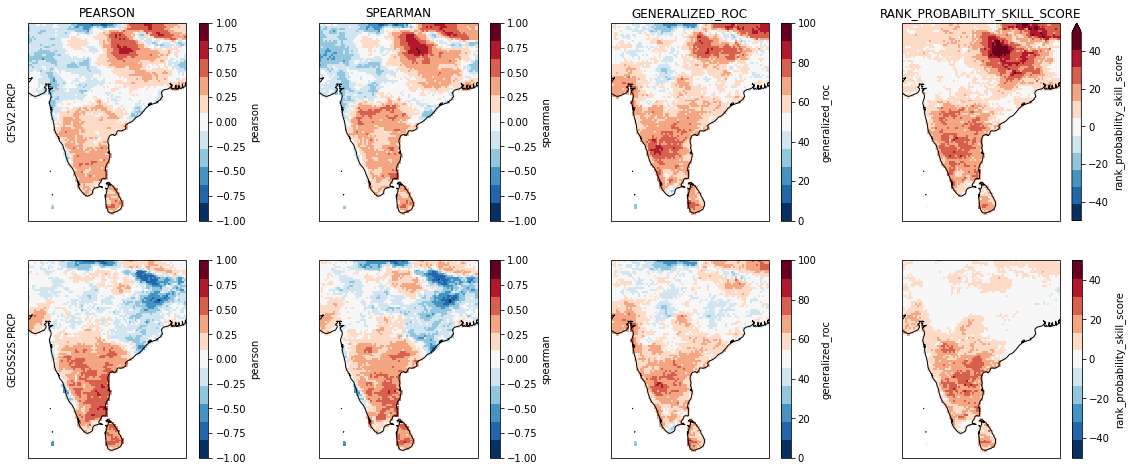

In [ ]:
print('\nPLOTTING SKILL SCORES')
skill_metrics = ['pearson', 'spearman', 'generalized_roc', 'rank_probability_skill_score']
#cmaps = [plt.get_cmap('cpt.correlation', 11), plt.get_cmap('cpt.correlation', 11), plt.get_cmap('RdBu_r', 11), plt.get_cmap('autumn_r', 11) ]
#limits = [(-1, 1), (-1, 1), (0, 100), (-35, 35)]
cmaps = [plt.get_cmap('RdBu_r', 11), plt.get_cmap('RdBu_r', 11), plt.get_cmap('RdBu_r', 11), plt.get_cmap('RdBu_r', 11) ]
limits = [(-1, 1), (-1, 1), (0, 100), (-50, 50)]

missing_value_flag = -999

fig, ax = plt.subplots(nrows=len(predictor_names), ncols=len(skill_metrics), subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(5*len(skill_metrics), 4*len(predictor_names)))
if len(predictor_names) == 1:
    ax = [ax]

for i, model in enumerate(predictor_names):
    for j, skill_metric in enumerate(skill_metrics):
        n = getattr(xr.open_dataset(case_directory / (model + '_skillscores_{}.nc'.format(MOS.lower()))), skill_metric)
        n.where(n > missing_value_flag).plot(ax=ax[i][j], cmap=cmaps[j], vmin=limits[j][0], vmax=limits[j][1])
        ax[i][j].coastlines()
        ax[0][j].set_title(skill_metric.upper())

    ax[i][0].text(-0.07, 0.55, model.upper(), va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax[i][0].transAxes)


# Individual Model EOF modes


PLOTTING EOF MODES (if MOS==CCA or MOS==PCR)
CFSV2.PRCP - MODE 1


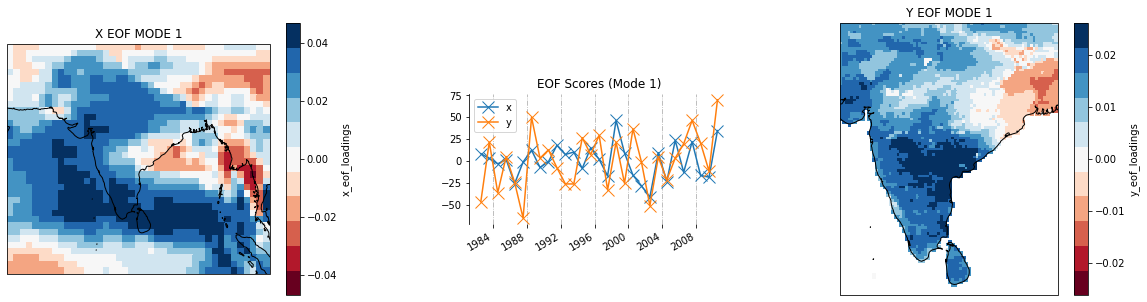

CFSV2.PRCP - MODE 2


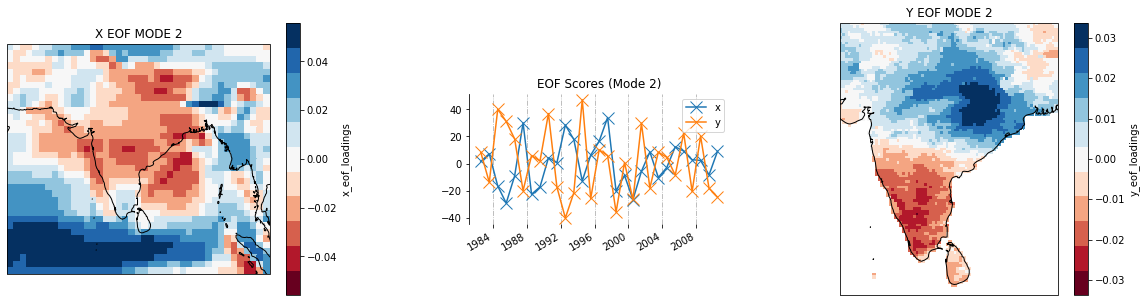

CFSV2.PRCP - MODE 3


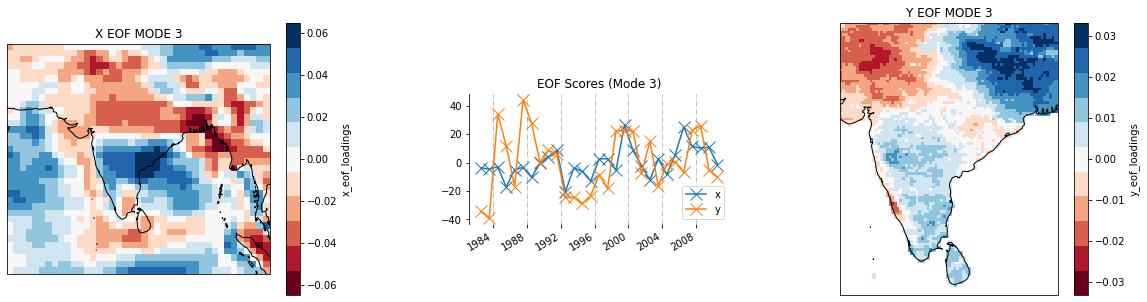

CFSV2.PRCP - MODE 4


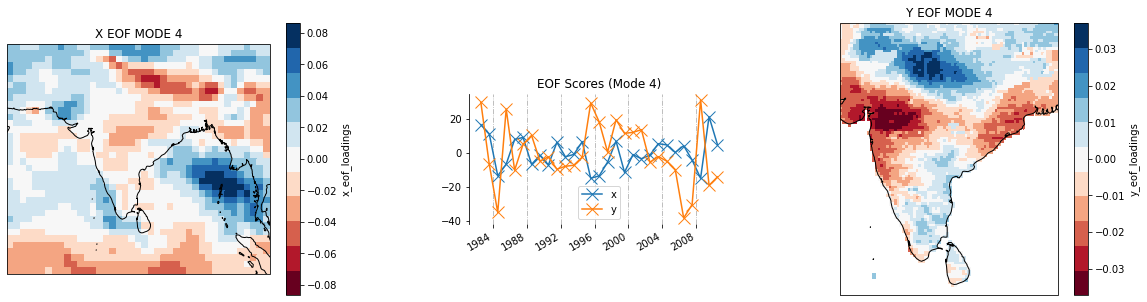

CFSV2.PRCP - MODE 5


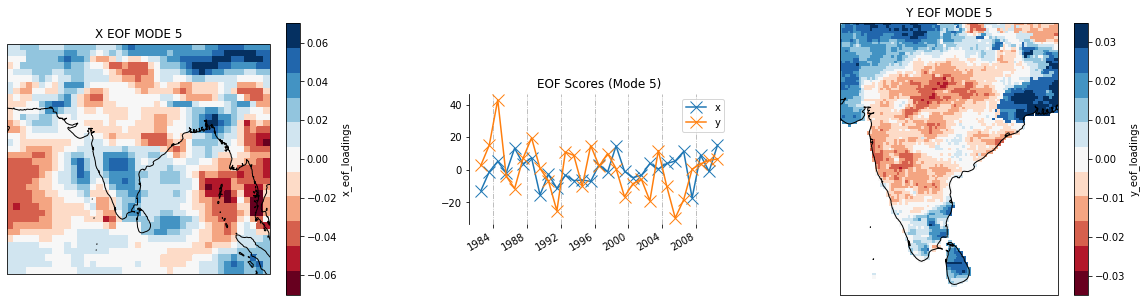

GEOSS2S.PRCP - MODE 1


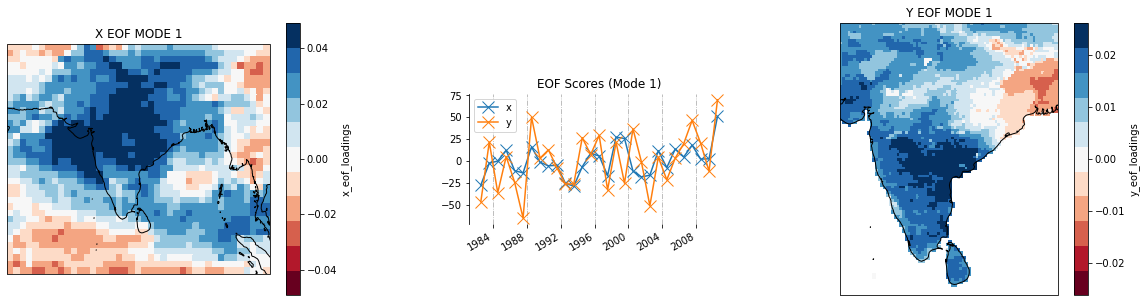

GEOSS2S.PRCP - MODE 2


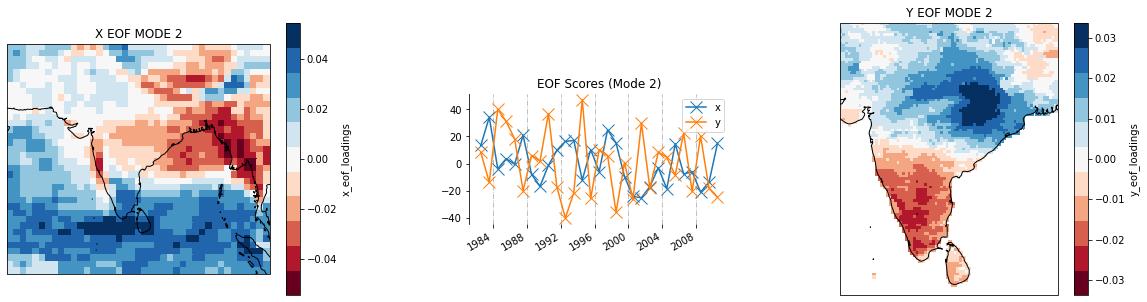

GEOSS2S.PRCP - MODE 3


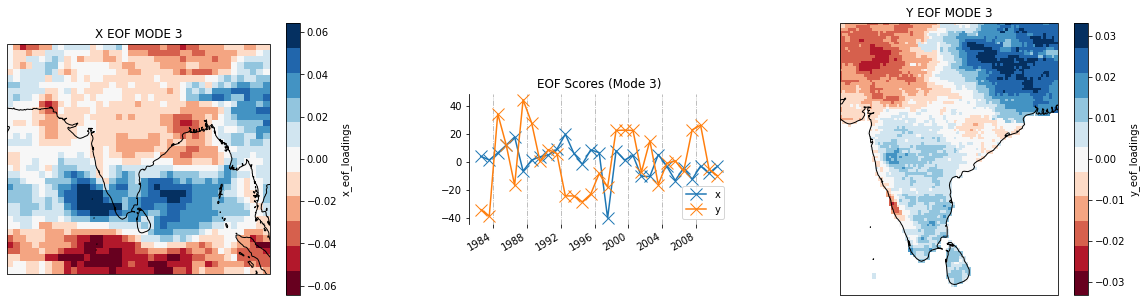

GEOSS2S.PRCP - MODE 4


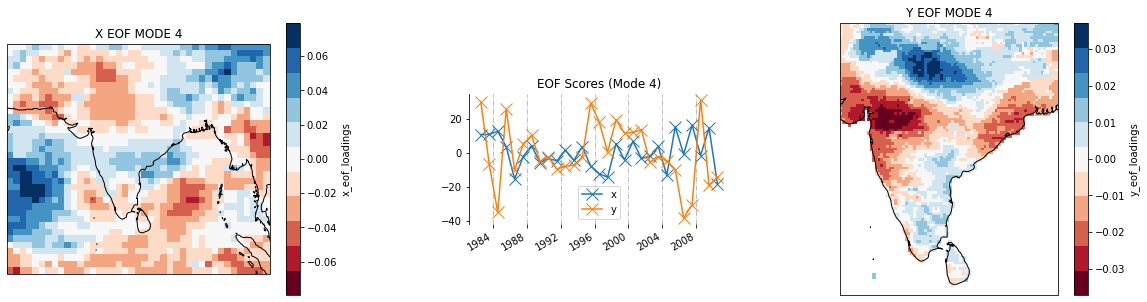

GEOSS2S.PRCP - MODE 5


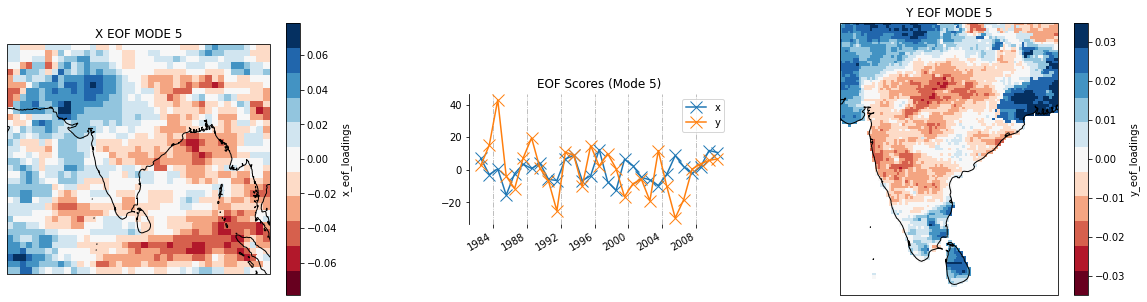

In [ ]:

print('\nPLOTTING EOF MODES (if MOS==CCA or MOS==PCR)')
nmodes = 5
cmap= plt.get_cmap('RdBu', 11)
vmin=-10
vmax = 10

import matplotlib.gridspec as gridspec
if MOS == 'CCA':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ' - MODE {}'.format(mode+1))
            px = xr.open_dataset(case_directory / (model + '_cca_x_spatial_loadings.nc'))
            py = xr.open_dataset(case_directory / (model + '_cca_y_spatial_loadings.nc'))

            fig = plt.figure(figsize=(20,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([px.x_eof_scores.isel(Mode=mode), py.y_eof_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x', 'y']})

            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())

            px.x_eof_loadings.isel(Mode=mode).where(px.x_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)
            py.y_eof_loadings.isel(Mode=mode).where(py.y_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('EOF Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)

            map1_ax.set_title('X EOF MODE {}'.format(mode+1))
            map2_ax.set_title('Y EOF MODE {}'.format(mode+1))

            map1_ax.coastlines()
            map2_ax.coastlines()
            plt.show()
elif MOS == 'PCR':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ' - MODE {}'.format(mode+1))
            px = xr.open_dataset(case_directory / (model + '_eof_x_spatial_loadings.nc'))

            fig = plt.figure(figsize=(20,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([pxs[i].x_eof_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x']})

            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())

            px.x_eof_loadings.isel(Mode=mode).where(px.x_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)            #pys[i].y_eof_loadings.isel(Mode=mode).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('EOF Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)

            map1_ax.set_title('X EOF MODE {}'.format(mode+1))
            #map2_ax.set_title('Y EOF MODE {}'.format(mode+1))

            map1_ax.coastlines()
            #map2_ax.coastlines()
            plt.show()
else:
    print('You will need to set MOS=CCA or MOS=PCR in order to see any EOF Modes')



## Individual Model CCA Modes


 PLOTTING CCA MODES (If MOS=CCA)
CFSV2.PRCP - MODE 1


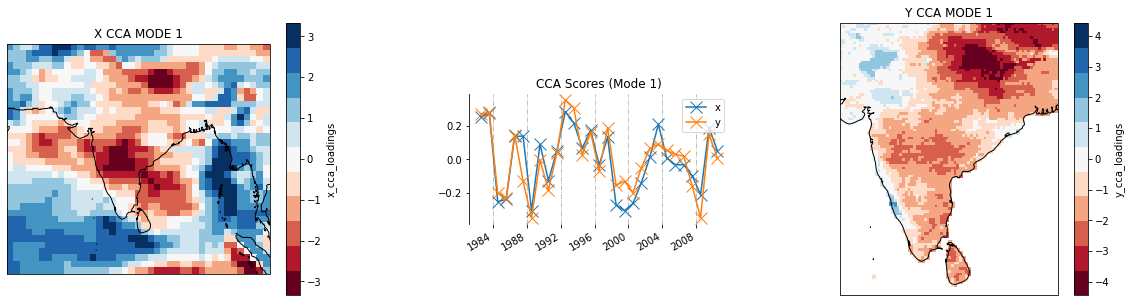

CFSV2.PRCP - MODE 2


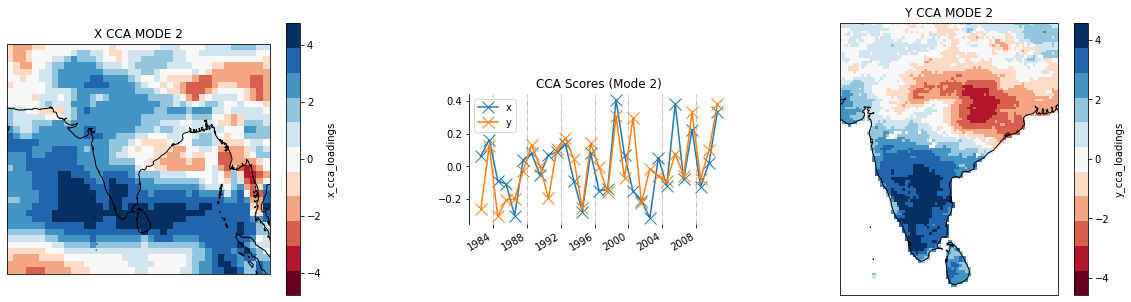

CFSV2.PRCP - MODE 3


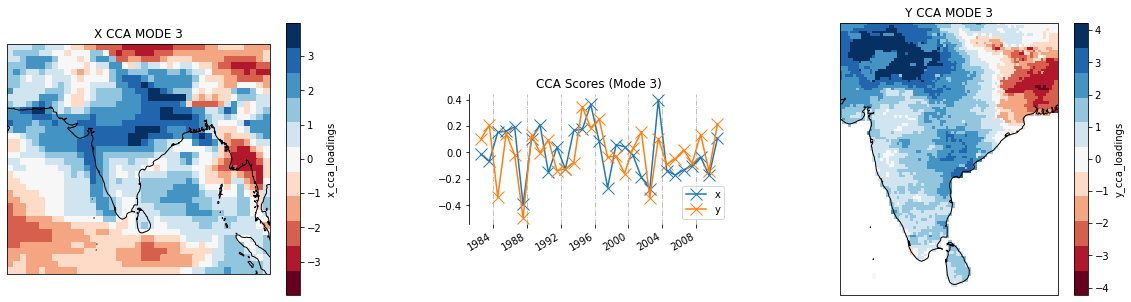

CFSV2.PRCP - MODE 4


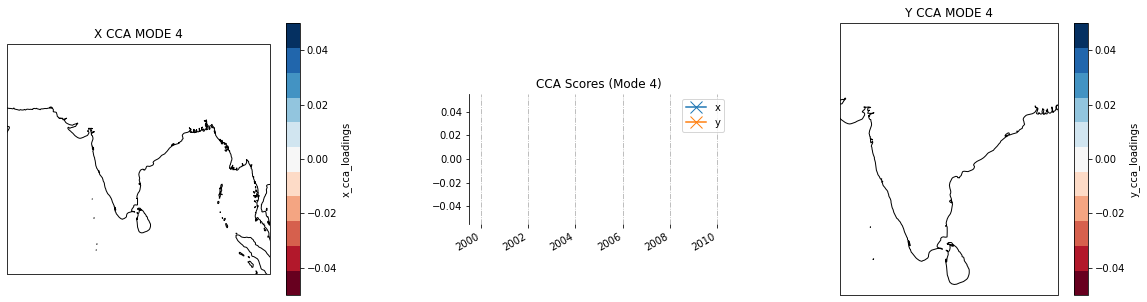

CFSV2.PRCP - MODE 5


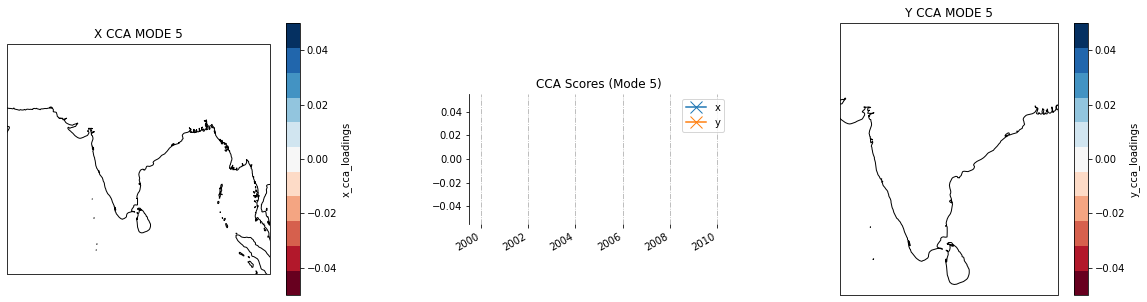

GEOSS2S.PRCP - MODE 1


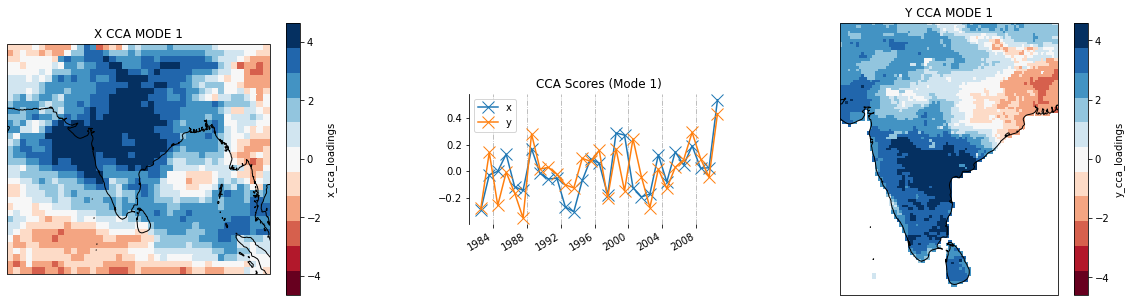

GEOSS2S.PRCP - MODE 2


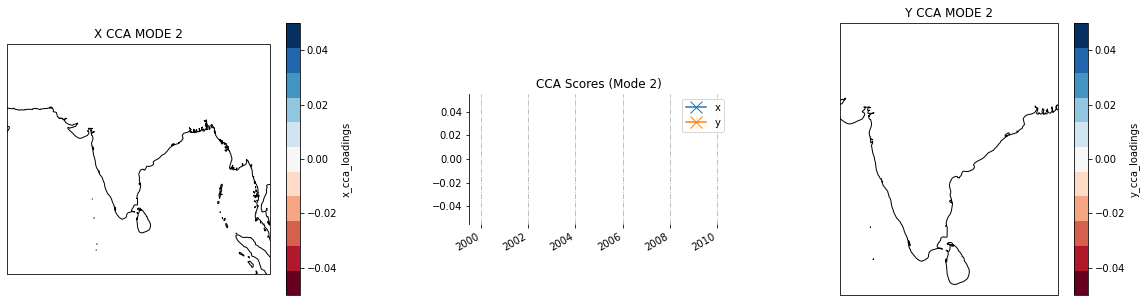

GEOSS2S.PRCP - MODE 3


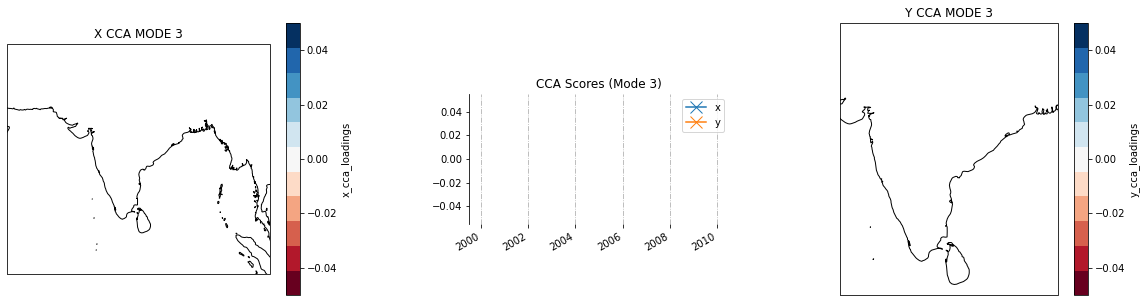

GEOSS2S.PRCP - MODE 4


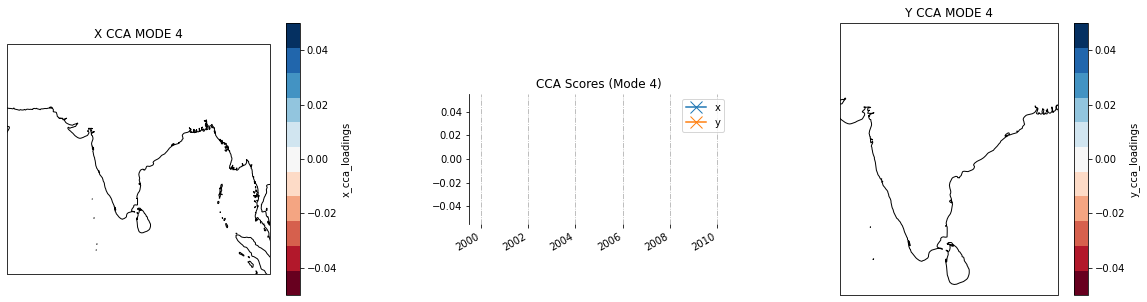

GEOSS2S.PRCP - MODE 5


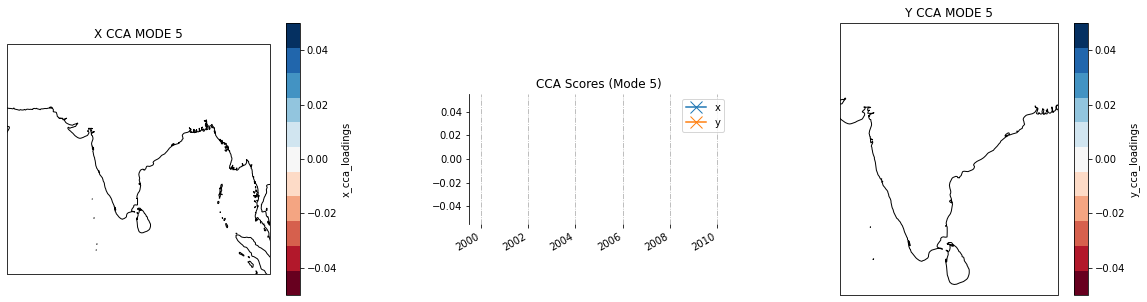

In [ ]:

print('\n PLOTTING CCA MODES (If MOS=CCA)')
nmodes = 5
cmap= plt.get_cmap('RdBu', 11)
vmin=-10
vmax = 10
missing_value_flag = -999

import matplotlib.gridspec as gridspec
if MOS == 'CCA':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ' - MODE {}'.format(mode+1))
            px = xr.open_dataset(case_directory / (model + '_cca_x_spatial_loadings.nc'))
            py = xr.open_dataset(case_directory / (model + '_cca_y_spatial_loadings.nc'))

            fig = plt.figure(figsize=(20,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([px.x_cca_scores.isel(Mode=mode), py.y_cca_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x', 'y']})

            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())

            px.x_cca_loadings.isel(Mode=mode).where(px.x_cca_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)
            py.y_cca_loadings.isel(Mode=mode).where(py.y_cca_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('CCA Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)

            map1_ax.set_title('X CCA MODE {}'.format(mode+1))
            map2_ax.set_title('Y CCA MODE {}'.format(mode+1))

            map1_ax.coastlines()
            map2_ax.coastlines()
            plt.show()
else:
    print('You will need to set MOS=CCA in order to see CCA Modes')

## Individual Model Real-Time Forecasts


PLOTTING REAL-TIME FORECASTS 
CFSV2.PRCP


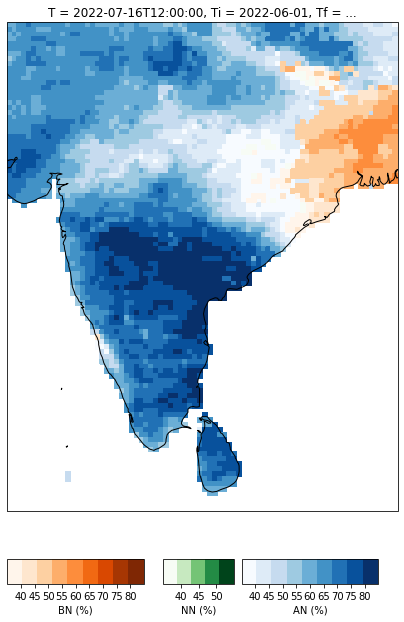

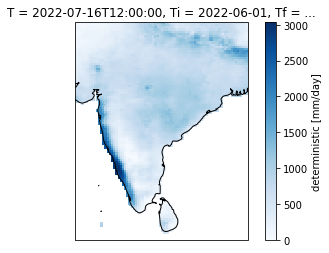

GEOSS2S.PRCP


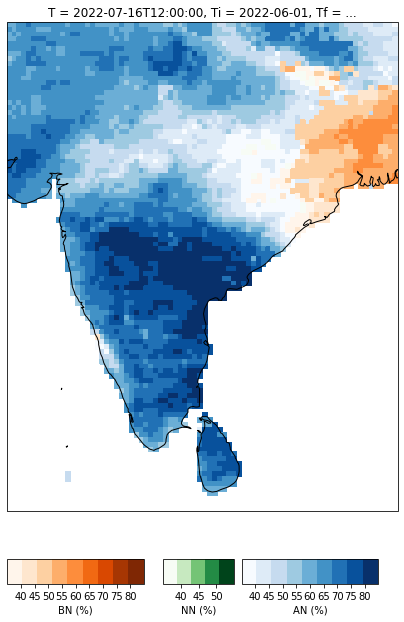

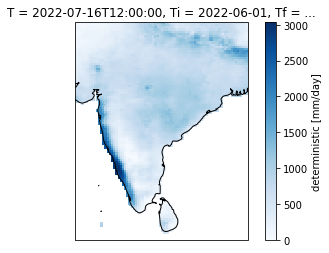

In [ ]:

print('\nPLOTTING REAL-TIME FORECASTS ')
missing_value_flag = -999
prob_missing_value_flag = -1
for i in range(len(predictor_names)):
    print(predictor_names[i].upper())
    fcst = xr.open_dataset(case_directory / (model + '_realtime_cca_forecasts.nc'))
    X = fcst.probabilistic.where(fcst.probabilistic > prob_missing_value_flag).rename({'C':'M'}).isel(T=-1) / 100
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 9), subplot_kw={'projection': ccrs.PlateCarree()})
    bounds = [40,45,50,55,60,65,70,75,80]
    nbounds = [40,45,50]
    mask = X.mean('M')
    mask = mask.where(np.isnan(mask), other=1)
    argmax = X.fillna(-999).argmax('M') * mask

    flat = mask.where(argmax != 2, other=X.isel(M=2))
    flat = flat.where(argmax != 1, other=X.isel(M=1))
    flat = flat.where(argmax != 0, other=X.isel(M=0)) * mask

    CS3 = flat.where(argmax == 2, other=np.nan).plot(ax=ax, add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('Blues', 9))
    CS1 = flat.where(argmax == 0, other=np.nan).plot(ax=ax, add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('Oranges', 9))
    CS2 = flat.where(argmax == 1, other=np.nan).plot(ax=ax, add_colorbar=False, vmin=0.35, vmax=0.55, cmap=plt.get_cmap('Greens', 5))

    ax.coastlines()
    axins_f_bottom = ax.inset_axes([0, -0.15, 0.35, 0.05 ],  transform=ax.transAxes   )
    axins2_bottom = ax.inset_axes((0.4, -0.15, 0.18, 0.05),  transform=ax.transAxes)
    axins3_bottom = ax.inset_axes((.6, -0.15, 0.35, 0.05), transform=ax.transAxes  )


    cbar_fbl = fig.colorbar(CS1, ax=ax, cax=axins_f_bottom, orientation='horizontal')
    cbar_fbl.set_label('BN (%)')
    cbar_fbl.set_ticks([i /100.0 for i in bounds])
    cbar_fbl.set_ticklabels(bounds)


    cbar_fbc = fig.colorbar(CS2, ax=ax,  cax=axins2_bottom, orientation='horizontal')
    cbar_fbc.set_label('NN (%)')
    cbar_fbc.set_ticks([i /100.0 for i in nbounds])
    cbar_fbc.set_ticklabels(nbounds)

    cbar_fbr = fig.colorbar(CS3, ax=ax,  cax=axins3_bottom, orientation='horizontal')
    cbar_fbr.set_label('AN (%)')
    cbar_fbr.set_ticks([i /100.0 for i in bounds])
    cbar_fbr.set_ticklabels(bounds)
    plt.show()

    art = fcst.deterministic.where(fcst.deterministic > missing_value_flag).isel(T=-1).plot(subplot_kws={'projection': ccrs.PlateCarree()}, cmap='Blues', vmin=0)
    art.axes.coastlines()
    plt.show()

# NextGen Ensemble Skill Scores


PLOTTING ENSEMBLE SKILL SCORES


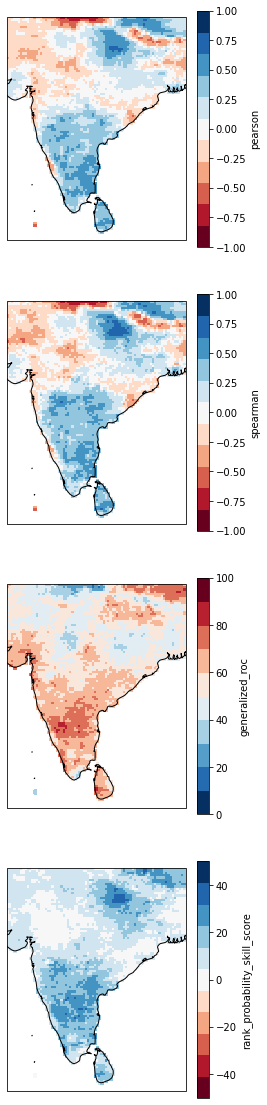

In [ ]:
print('\nPLOTTING ENSEMBLE SKILL SCORES')
skill_metrics = ['pearson', 'spearman', 'generalized_roc', 'rank_probability_skill_score']
#cmaps = [plt.get_cmap('RdBu', 11), plt.get_cmap('RdBu', 11), plt.get_cmap('autumn_r', 10), plt.get_cmap('autumn_r', 11) ]
#limits = [(-1, 1), (-1, 1), (50, 100), (0, 50)]
cmaps = [plt.get_cmap('RdBu', 11), plt.get_cmap('RdBu', 11), plt.get_cmap('RdBu_r', 10), plt.get_cmap('RdBu', 11) ]
limits = [(-1, 1), (-1, 1), (0, 100), (-50, 50)]
cmaps[2].set_under('lightgray')
cmaps[3].set_under('lightgray')

nextgen_skill = xr.open_dataset(case_directory / ('nextgen_skillscores.nc'))
## Do not modify below
fig, ax = plt.subplots(nrows=len(skill_metrics), ncols=1, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(4, 5*len(skill_metrics)))
for j, skill_metric in enumerate(skill_metrics):
    ax[j].set_title(skill_metric)
    getattr(nextgen_skill, skill_metric).where(getattr(nextgen_skill, skill_metric) > missing_value_flag).plot(ax=ax[j], cmap=cmaps[j], vmin=limits[j][0], vmax=limits[j][1])
    ax[j].coastlines()


# NextGen Ensemble Real-Time Forecast

PLOTTING ENSEMBLE REAL-TIME FORECASTS


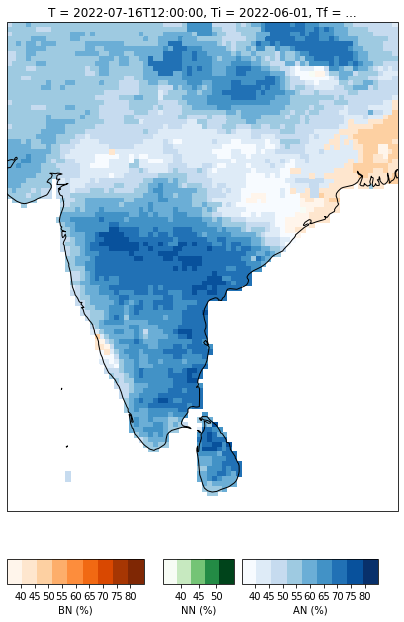

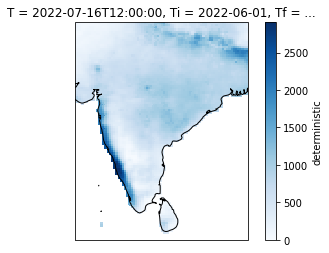

In [ ]:
print('PLOTTING ENSEMBLE REAL-TIME FORECASTS')
missing_value_flag = -999
prob_missing_value_flag = -1


pr_fcst = xr.open_dataset(case_directory / ('nextgen_probabilistic_forecast.nc'))
pr_fcst = getattr(pr_fcst, [i for i in pr_fcst.data_vars][0])

det_fcst = xr.open_dataset(case_directory / ('nextgen_deterministic_forecast.nc'))
det_fcst = getattr(det_fcst, [i for i in det_fcst.data_vars][0])

X = pr_fcst.where(pr_fcst > prob_missing_value_flag).rename({'C':'M'}).isel(T=-1) / 100

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 9), subplot_kw={'projection': ccrs.PlateCarree()})
bounds = [40,45,50,55,60,65,70,75,80]
nbounds = [40,45,50]
mask = X.mean("M")
mask = mask.where(np.isnan(mask), other=1)
argmax = X.fillna(-999).argmax('M') * mask

flat = mask.where(argmax != 2, other=X.isel(M=2))
flat = flat.where(argmax != 1, other=X.isel(M=1))
flat = flat.where(argmax != 0, other=X.isel(M=0)) * mask

CS3 = flat.where(argmax == 2, other=np.nan).plot(ax=ax, add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('Blues', 9))
CS1 = flat.where(argmax == 0, other=np.nan).plot(ax=ax, add_colorbar=False, vmin=0.35, vmax=0.85, cmap=plt.get_cmap('Oranges', 9))
CS2 = flat.where(argmax == 1, other=np.nan).plot(ax=ax, add_colorbar=False, vmin=0.35, vmax=0.55, cmap=plt.get_cmap('Greens', 5))

ax.coastlines()
axins_f_bottom = ax.inset_axes([0, -0.15, 0.35, 0.05 ],  transform=ax.transAxes   )
axins2_bottom = ax.inset_axes((0.4, -0.15, 0.18, 0.05),  transform=ax.transAxes)
axins3_bottom = ax.inset_axes((.6, -0.15, 0.35, 0.05), transform=ax.transAxes  )

cbar_fbl = fig.colorbar(CS1, ax=ax, cax=axins_f_bottom, orientation='horizontal')
cbar_fbl.set_label('BN (%)')
cbar_fbl.set_ticks([i /100.0 for i in bounds])
cbar_fbl.set_ticklabels(bounds)


cbar_fbc = fig.colorbar(CS2, ax=ax,  cax=axins2_bottom, orientation='horizontal')
cbar_fbc.set_label('NN (%)')
cbar_fbc.set_ticks([i /100.0 for i in nbounds])
cbar_fbc.set_ticklabels(nbounds)

cbar_fbr = fig.colorbar(CS3, ax=ax,  cax=axins3_bottom, orientation='horizontal')
cbar_fbr.set_label('AN (%)')
cbar_fbr.set_ticks([i /100.0 for i in bounds])
cbar_fbr.set_ticklabels(bounds)
plt.show()
plt.show()
art = det_fcst.where(det_fcst > missing_value_flag).isel(T=-1).plot(subplot_kws={'projection': ccrs.PlateCarree()}, cmap='Blues', vmin=0)
art.axes.coastlines()
plt.show()

# Exceedance Probability

{'MOS': 'CCA', 'cpt_args': {'cca_modes': [1, 6], 'crossvalidation_window': 5, 'drymask': False, 'scree': True, 'synchronous_predictors': True, 'tailoring': 'None', 'transform_predictand': 'Empirical', 'validation': 'crossvalidation', 'x_eof_modes': [1, 8], 'y_eof_modes': [1, 6]}, 'cptcore_version': '1.0.8', 'cptdl_version': '1.0.3', 'cptextras_version': '1.0.2', 'cptio_version': '1.0.1', 'download_args': {'fdate': '2022-05-01', 'filetype': 'cptv10.tsv', 'final_year': 2010, 'first_year': 1982, 'lead_high': 3.5, 'lead_low': 1.5, 'predictand_extent': {'east': 90, 'north': 30, 'south': 5, 'west': 70}, 'predictor_extent': {'east': 100, 'north': 35, 'south': 0, 'west': 60}, 'target': 'Jun-Aug'}, 'predictand': 'UCSB.PRCP', 'predictors': ['CFSv2.PRCP', 'GEOSS2S.PRCP']}

PLOTTING POEs, PDFs, and CDFs 


/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


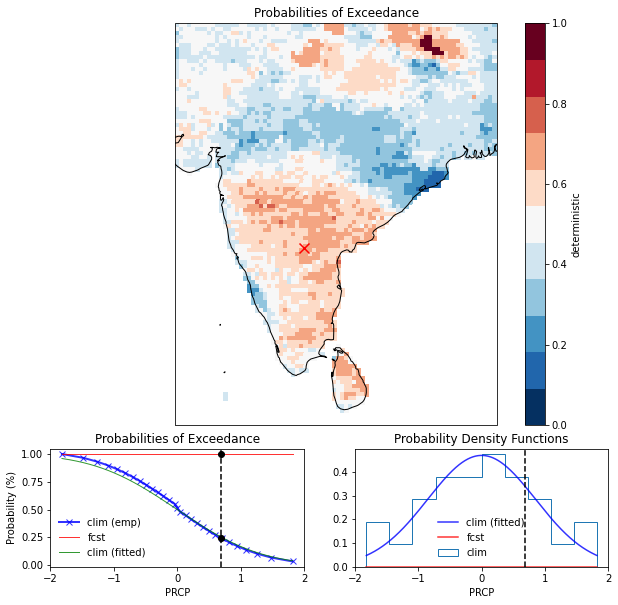

In [ ]:
point_latitude = 16
point_longitude = 78


import json
with open(case_directory / 'config.json') as f:
    settings = json.loads(f.read())

print(settings)

exceedance_prob = xr.open_dataset(case_directory / ('nextgen_exceedance_prob.nc'))
exceedance_prob = getattr(exceedance_prob, [i for i in exceedance_prob.data_vars][0])

threshold = xr.open_dataset(case_directory / ('nextgen_poe_threshold.nc'))
threshold = getattr(threshold, [i for i in threshold.data_vars][0])

fcst_scale = xr.open_dataset(case_directory / ('nextgen_poe_fcst_scale.nc'))
fcst_scale = getattr(fcst_scale, [i for i in fcst_scale.data_vars][0])

climo_scale = xr.open_dataset(case_directory / ('nextgen_poe_climo_scale.nc'))
climo_scale = getattr(climo_scale, [i for i in climo_scale.data_vars][0])

fcst_mu = xr.open_dataset(case_directory / ('nextgen_transformed_fcst_mu.nc'))
fcst_mu = getattr(fcst_mu, [i for i in fcst_mu.data_vars][0])

climo_mu = xr.open_dataset(case_directory / ('nextgen_climo_mu.nc'))
climo_mu = getattr(climo_mu, [i for i in climo_mu.data_vars][0])

Y2 = xr.open_dataset(case_directory / ('nextgen_y2.nc'))
Y2 = getattr(Y2, [i for i in Y2.data_vars][0])

Y = xr.open_dataset(case_directory / ('nextgen_y.nc'))
Y = getattr(Y, [i for i in Y.data_vars][0])

transformer = None if settings['cpt_args']['transform_predictand'] == 'None' else settings['cpt_args']['transform_predictand']

ntrain = Y.shape[list(Y.dims).index('T')]

print('\nPLOTTING POEs, PDFs, and CDFs ')
cmap=plt.get_cmap('RdBu_r', 11)

from scipy.stats import t, norm
# setting up canvas on which to draw
fig = plt.figure(figsize=(10,10))
gs0 = gridspec.GridSpec(4, 1, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs0[:3])
gs11 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[3])
gs01 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs11[0])
gs02 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs11[1])

map_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
cdf_ax = fig.add_subplot(gs01[:,:])
pdf_ax = fig.add_subplot(gs02[:,:])

#plot the map
art = exceedance_prob.transpose('Y', 'X', ...).plot(cmap=cmap,  ax=map_ax, vmin=0, vmax=1)
map_ax.scatter([point_longitude], [point_latitude], marker='x', s=100, color='red', transform=ccrs.PlateCarree())
coasts = art.axes.coastlines()

#point calculations - select the nearest point to the lat/lon the user wanted to plot curves
point_threshold = float(threshold.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_fcst_scale = float(fcst_scale.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo_scale = float(climo_scale.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_fcst_mu = float(fcst_mu.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo_mu = float(climo_mu.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo = np.squeeze(Y2.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo.sort()

if transformer is not None:
    point_climo_mu_nontransformed = float(Y.mean('T').sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
    point_climo_std_nontransformed = float(Y.std('T').sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)


x = point_climo
x1 =np.linspace(x.min(), x.max(), 1000)
cprobth =  sum(x >= point_threshold) / x.shape[0]  #round(t.sf(point_threshold, ntrain, loc=point_climo_mu, scale=point_climo_scale),2)
fprobth = round(t.sf(point_threshold, ntrain, loc=point_fcst_mu, scale=point_fcst_scale),2)



cdf_ax.plot(x, [ sum(x >= x[i]) / x.shape[0] for i in range(x.shape[0]) ],'b-', lw=2, marker='x', alpha=0.8, label='clim (emp)')
cdf_ax.plot(x1, t.sf(x1, ntrain, loc=point_fcst_mu, scale=point_fcst_scale),'r-',  lw=1, alpha=0.8, label='fcst')
cdf_ax.plot(x1, norm.sf(x1, loc=point_climo_mu, scale=point_fcst_scale),'g-', lw=1, alpha=0.8, label='clim (fitted)')


cdf_ax.plot(point_threshold, fprobth,'ok')
cdf_ax.plot(point_threshold, cprobth,'ok')
cdf_ax.axvline(x=point_threshold, color='k', linestyle='--')
cdf_ax.set_title('Probabilities of Exceedance')
cdf_ax.set_xlabel(Y.name.upper())
cdf_ax.set_ylabel('Probability (%)')
cdf_ax.legend(loc='best', frameon=False)

fpdf=t.pdf(x1, ntrain, loc=point_fcst_mu, scale=np.sqrt(point_fcst_scale))
pdf_ax.plot(x1, norm.pdf(x1, loc=point_climo_mu, scale =point_climo_scale), 'b-', alpha=0.8, label='clim (fitted)')
pdf_ax.plot(x1, fpdf, 'r-',  alpha=0.8, label='fcst')
pdf_ax.hist(point_climo, density=True, histtype='step', label='clim')

pdf_ax.axvline(x=point_threshold, color='k', linestyle='--')
pdf_ax.legend(loc='best', frameon=False)
pdf_ax.set_title('Probability Density Functions')
pdf_ax.set_xlabel(Y.name.upper())
pdf_ax.set_ylabel('')

if transformer is not None:
    newticks = [-2, -1, 0, 1, 2]
    pdf_ax.set_xticks(newticks, [round(i * point_climo_std_nontransformed + point_climo_mu_nontransformed, 2) for i in newticks])
    cdf_ax.set_xticks(newticks, [round(i * point_climo_std_nontransformed + point_climo_mu_nontransformed, 2) for i in newticks])

title = map_ax.set_title('Probabilities of Exceedance')